# Sentiment Analysis with Random Forest
This notebook trains a sentiment analysis model using Random Forest on a balanced dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import pickle

In [2]:
# Load the dataset
file_path = 'Balanced_Reviews(500).csv'
data = pd.read_csv(file_path)

# Convert rating column to numeric
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')
data = data.dropna(subset=['rating'])
data['rating'] = data['rating'].astype(int)

# Create sentiment column
data['sentiment'] = data['rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

In [3]:
# Drop NaN values in content
data = data.dropna(subset=['content'])

# Separate majority and minority classes
positive = data[data.sentiment == 'positive']
neutral = data[data.sentiment == 'neutral']
negative = data[data.sentiment == 'negative']

In [4]:
# Upsample minority classes
neutral_upsampled = resample(neutral,
                             replace=True,     # sample with replacement
                             n_samples=len(positive),    # to match majority class
                             random_state=42) # reproducible results
negative_upsampled = resample(negative,
                              replace=True,     # sample with replacement
                              n_samples=len(positive),    # to match majority class
                              random_state=42) # reproducible results

# Combine majority class with upsampled minority classes
upsampled = pd.concat([positive, neutral_upsampled, negative_upsampled])

# Text data for training
X = upsampled['content']
y = upsampled['sentiment']

In [5]:
# Split the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Validate the model
y_val_pred = model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Test the model
y_test_pred = model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)


In [6]:
# Print validation results
print('Validation Accuracy:', val_accuracy)
print('Validation Classification Report:')
print(val_report)

Validation Accuracy: 0.96875
Validation Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94        27
     neutral       1.00      1.00      1.00        34
    positive       0.94      0.97      0.96        35

    accuracy                           0.97        96
   macro avg       0.97      0.97      0.97        96
weighted avg       0.97      0.97      0.97        96



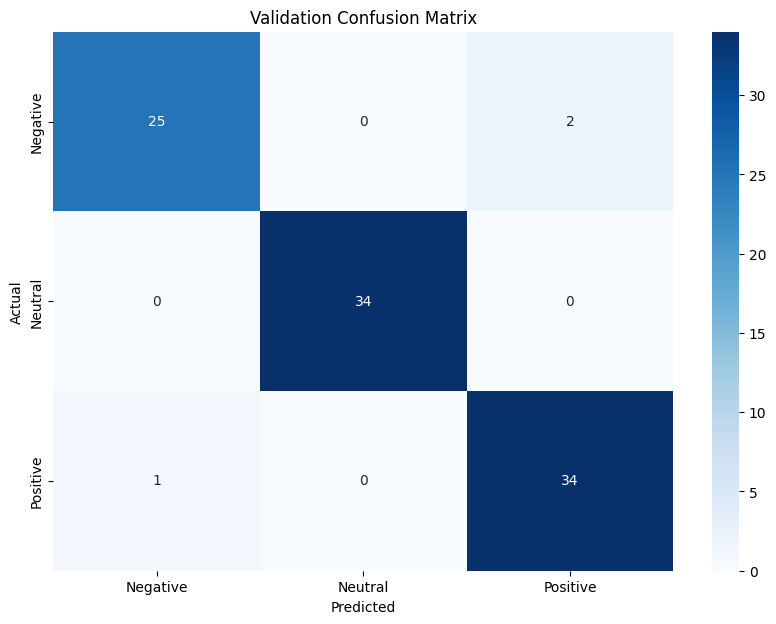

In [7]:
# Plot validation confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

Test Accuracy: 0.9333333333333333
Test Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.88      0.94        41
     neutral       0.92      0.97      0.95        36
    positive       0.89      0.95      0.92        43

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120



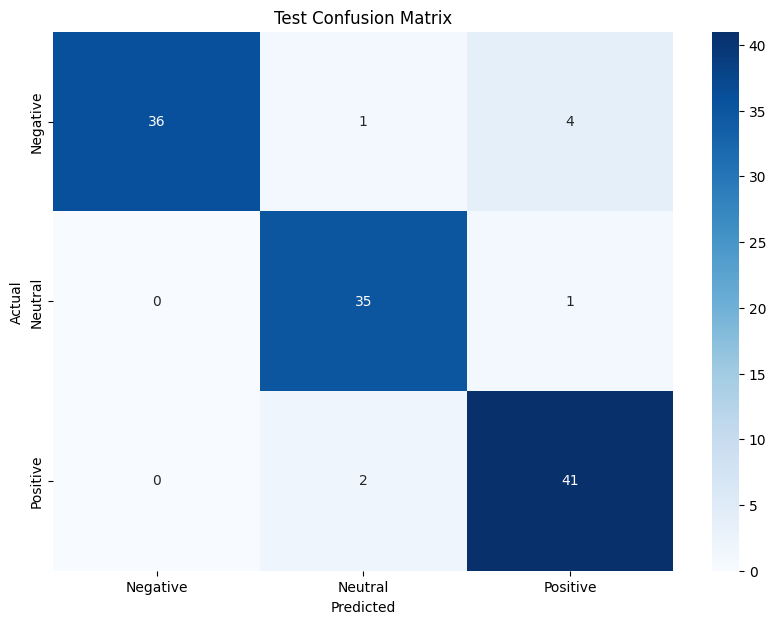

In [8]:
# Print test results
print('Test Accuracy:', test_accuracy)
print('Test Classification Report:')
print(test_report)

# Plot test confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()


In [9]:
# Test a single review
test_review = ["The product quality is decent but not as expected. It works fine for basic tasks but struggles with more demanding applications. Overall, it's an average product."]

# Transform the review using the TF-IDF vectorizer
test_review_tfidf = vectorizer.transform(test_review)

# Predict the sentiment
test_review_pred = model.predict(test_review_tfidf)

# Print the predicted sentiment
print("Test Review Sentiment:", test_review_pred[0])


Test Review Sentiment: positive


In [10]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model.score(X_train_tfidf, y_train))
print("Testing Accuracy :", model.score(X_test_tfidf, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9333333333333333


In [11]:
accuracies = cross_val_score(estimator = model, X = X_train_tfidf, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9165317139001349
Standard Variance : 0.04010056228653486


In [12]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [13]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_tfidf, y_train.ravel())

C:\Users\asus\AppData\Local\Temp\ipykernel_21936\1198252231.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_train_tfidf, y_train.ravel())


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [14]:
#Getting the best parameters from the grid search

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [15]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_test_pred))

Cross validation mean accuracy on train set : 99.34895833333334
Cross validation mean accuracy on test set : 87.63020833333333
Accuracy score for test set : 0.9333333333333333


In [16]:
#Saving the Random Forest classifier
pickle.dump(model, open('Models/RandomForest.pkl', 'wb'))